In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras 
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout


In [3]:
def plot_imgs(directory, top=10):
    all_item_dirs = os.listdir(directory)
    item_files = [os.path.join(directory, file) for file in all_item_dirs][:5]
  
    plt.figure(figsize=(20, 20))
  
    for i, img_path in enumerate(item_files):
        plt.subplot(10, 10, i+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray')

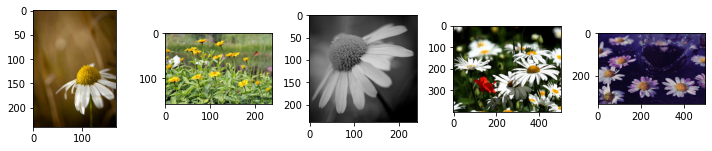

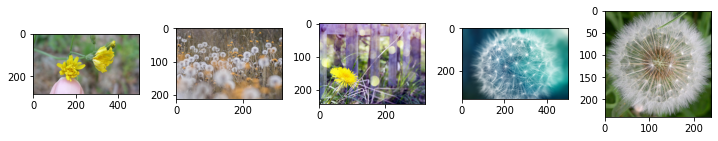

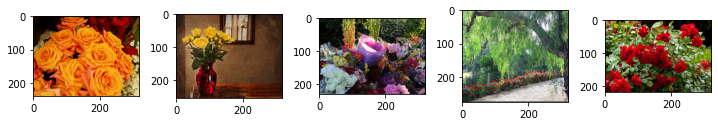

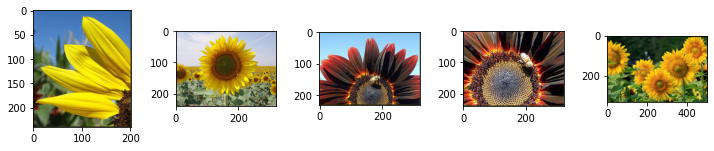

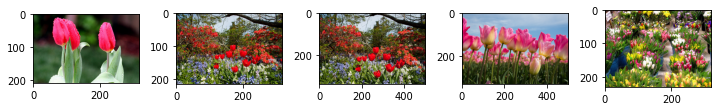

In [4]:
data_path = '/content/drive/MyDrive/shapeai/project 2'

directories = ['/Daisy', '/Dandelion', '/Rose', '/Sunflower', '/Tulip']

for j in directories:
    plot_imgs(data_path+j)

In [4]:
rootdir = '/content/drive/MyDrive/shapeai/project 2'
classes = ['/Daisy', '/Dandelion', '/Rose', '/Sunflower', '/Tulip']

# **Data Spliting**

In [ ]:
#split data into 2 parts,train and test data
for i in classes:
  os.makedirs(rootdir +'/train/' + i)
  os.makedirs(rootdir +'/test/' + i)

  source = rootdir + '/' + i

  allFileNames = os.listdir(source)
  np.random.shuffle(allFileNames)
  
  test_ratio = 0.25
  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - test_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train/' + i)

  for name in test_FileNames:
    shutil.copy(name, rootdir +'/test/' + i)

In [ ]:
#split test data into two parts, test and valid data 
rootdi = '/content/drive/MyDrive/shapeai/project 2/test'
for i in classes:
  os.makedirs(rootdi +'/test/' + i)
  os.makedirs(rootdi +'/valid/' + i)

  source = rootdi + '/' + i

  allFileNames = os.listdir(source)
  np.random.shuffle(allFileNames)
  
  test_ratio = 0.4
  valid_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - test_ratio))])

  valid_FileNames = [source+'/'+ name for name in valid_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in valid_FileNames:
    shutil.copy(name, rootdi +'/valid/' + i)

  for name in test_FileNames:
    shutil.copy(name, rootdi +'/test/' + i)

In [5]:
#data path
train_data_path = '/content/drive/MyDrive/shapeai/project 2/train'
test_data_path = '/content/drive/MyDrive/shapeai/project 2/test/test'
valid_data_path = '/content/drive/MyDrive/shapeai/project 2/test/valid'

# **Data Preprocessing**

In [6]:
batch_size = 128
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                  rescale = 1./255, 
                                  zoom_range = 0.2,                             
                                  featurewise_center=False,  
                                  samplewise_center=False,  
                                  featurewise_std_normalization=False, 
                                  samplewise_std_normalization=False,  
                                  zca_whitening=False, 
                                  rotation_range=10,  
                                  width_shift_range=0.2,  
                                  height_shift_range=0.2, 
                                  vertical_flip=False)

train_data = train_datagen.flow_from_directory(train_data_path, target_size = (120,120),
                                              batch_size = batch_size, 
                                              color_mode = 'grayscale',
                                              class_mode = 'categorical')
train_data_image , train_data_label = next(train_data)

Found 3244 images belonging to 5 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_data = test_datagen.flow_from_directory(test_data_path, target_size = (120,120),
                                              batch_size = batch_size, 
                                              color_mode = 'grayscale',
                                              class_mode = 'categorical')
test_data_image , test_data_label = next(test_data)

Found 436 images belonging to 5 classes.


In [8]:
valid_datagen = ImageDataGenerator(horizontal_flip = True, 
                                  rescale = 1./255, 
                                  zoom_range = 0.2,                             
                                  featurewise_center=False,  
                                  samplewise_center=False,  
                                  featurewise_std_normalization=False, 
                                  samplewise_std_normalization=False,  
                                  zca_whitening=False, 
                                  rotation_range=10,  
                                  width_shift_range=0.2,  
                                  height_shift_range=0.2, 
                                  vertical_flip=False)

valid_data = test_datagen.flow_from_directory(valid_data_path, target_size = (120,120),
                                              batch_size = batch_size, 
                                              color_mode = 'grayscale',
                                              class_mode = 'categorical')
valid_data_image , valid_data_label = next(valid_data)

Found 647 images belonging to 5 classes.


# **Build a Model**

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu',
                           input_shape=(120,120,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(5,  activation='softmax')
])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 120, 120, 32)      832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28800)            

In [21]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [22]:
history = model.fit(train_data, epochs=40,validation_data=valid_data,verbose=2)

Epoch 1/40
26/26 - 21s - loss: 1.5904 - accuracy: 0.2700 - val_loss: 1.5235 - val_accuracy: 0.3168
Epoch 2/40
26/26 - 19s - loss: 1.5191 - accuracy: 0.3209 - val_loss: 1.4955 - val_accuracy: 0.3431
Epoch 3/40
26/26 - 19s - loss: 1.4566 - accuracy: 0.3748 - val_loss: 1.3875 - val_accuracy: 0.4173
Epoch 4/40
26/26 - 19s - loss: 1.4316 - accuracy: 0.4075 - val_loss: 1.4211 - val_accuracy: 0.4003
Epoch 5/40
26/26 - 19s - loss: 1.3891 - accuracy: 0.4057 - val_loss: 1.3523 - val_accuracy: 0.4235
Epoch 6/40
26/26 - 19s - loss: 1.3564 - accuracy: 0.4306 - val_loss: 1.3097 - val_accuracy: 0.4328
Epoch 7/40
26/26 - 19s - loss: 1.3391 - accuracy: 0.4448 - val_loss: 1.3272 - val_accuracy: 0.4544
Epoch 8/40
26/26 - 19s - loss: 1.2945 - accuracy: 0.4661 - val_loss: 1.2949 - val_accuracy: 0.4714
Epoch 9/40
26/26 - 19s - loss: 1.2817 - accuracy: 0.4797 - val_loss: 1.2091 - val_accuracy: 0.5100
Epoch 10/40
26/26 - 19s - loss: 1.2470 - accuracy: 0.4975 - val_loss: 1.2185 - val_accuracy: 0.5394
Epoch 11/

In [ ]:

import pickle
pickle.dump(model, open('/content/drive/MyDrive/shapeai/project 2/Model1.pkl', 'wb'))

In [36]:
#save model for future prediction 
model.save('/content/drive/MyDrive/shapeai/project 2/model.h5')

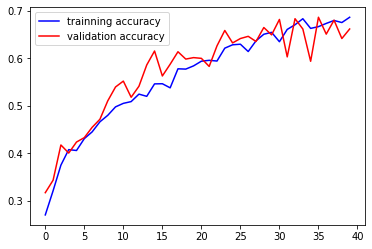

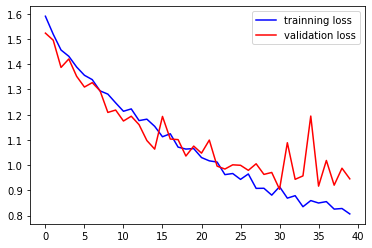

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [25]:
#Predict the Model on Test Set
prediction=model.predict(x=test_data)

In [28]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true=test_data.classes,y_pred=np.argmax(prediction,axis=-1))

In [33]:
import itertools
def plot_confusion_matrix(cm,classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks =np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    else:
        print('Confusion matrix,without normalization')
    print(cm)
    thresh=cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j]> thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted data')


In [31]:
test_data.class_indices

{'Daisy': 0, 'Dandelion': 1, 'Rose': 2, 'Sunflower': 3, 'Tulip': 4}

Confusion matrix,without normalization
[[ 8 12 17 15 25]
 [12 19 21 22 33]
 [ 7 16 14 24 18]
 [ 4 22 13 22 13]
 [11 21 16 33 18]]


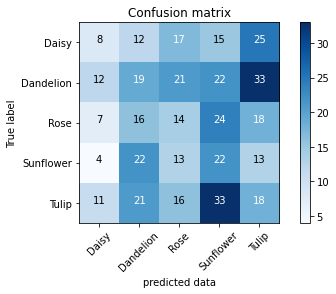

In [34]:
cm_plot_labels=['Daisy','Dandelion','Rose','Sunflower','Tulip']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion matrix')